In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.mortality.final_model_loss_train_mortality import *
from model.final_model.mortality.final_model_mortality import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.plot import *
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()


In [2]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)

# ## load the inbalanced dataset sampler
# labels_train = [int(dataset_train[i][5]) for i in range(len(dataset_train))]
# labels_val = [int(dataset_val[i][5]) for i in range(len(dataset_val))]
# labels_test = [int(dataset_test[i][5]) for i in range(len(dataset_test))]

# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)
# val_sampler = ImbalancedDatasetSampler(dataset_val, labels=labels_val)
# test_sampler = ImbalancedDatasetSampler(dataset_test, labels=labels_test)

## build the dataloader
# train_loader = DataLoader( dataset_train,batch_size=16,sampler=train_sampler,collate_fn=collate_fn )
# val_loader = DataLoader( dataset_val,batch_size=16,sampler=val_sampler,collate_fn=collate_fn)
# test_loader = DataLoader( dataset_test,batch_size=16,sampler=test_sampler,collate_fn=collate_fn )
train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=32,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=32,shuffle=False,collate_fn=collate_fn )
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [3]:
from torch.utils.data import Subset


train_loader = DataLoader( dataset_train,batch_size=32,shuffle=False,collate_fn=collate_fn )

batch = next(iter(train_loader))
*_, original_indices = batch
small_ids = original_indices.tolist()

small_subset = Subset(dataset_train, small_ids)

small_train_loader = DataLoader(
    small_subset,
    batch_size=len(small_ids),
    shuffle=True,
    collate_fn=collate_fn
)
small_train_loader_p = DataLoader(
    small_subset,
    batch_size=len(small_ids),
    shuffle=False,
    collate_fn=collate_fn
)

In [4]:

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [ ]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_mortality_30"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_mortality_30/combine_debug"


model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=100, save_dir=save_path, 
            theta=1, gamma=1, kappa=1, beta=10, eta=1,
            patience = 50 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Epoch 10/100 - Train Loss: 12472.6282, Mortality Loss: 14.4823, Val Loss: -11.0203


[Joint] Ep20: Calculating global target P...


[Joint] Epoch 20/100 - Train Loss: 12461.5127, Mortality Loss: 3.3220, Val Loss: -9.7422


[Joint] Ep30: Calculating global target P...


[Joint] Epoch 30/100 - Train Loss: 12458.3596, Mortality Loss: 0.1766, Val Loss: -6.9595


[Joint] Ep40: Calculating global target P...


[Joint] Epoch 40/100 - Train Loss: 12458.5610, Mortality Loss: 0.3897, Val Loss: -6.5691


[Joint] Ep50: Calculating global target P...


[Joint] Epoch 50/100 - Train Loss: 12458.5512, Mortality Loss: 0.3498, Val Loss: -6.2042


[Joint] Ep60: Calculating global target P...


[Joint] Epoch 60/100 - Train Loss: 12458.1869, Mortality Loss: 0.0196, Val Loss: -5.2403


[Joint] Early stopping at epoch 63 due to no improvement for 50 epochs.
[Joint] Loading best model weights.


: 

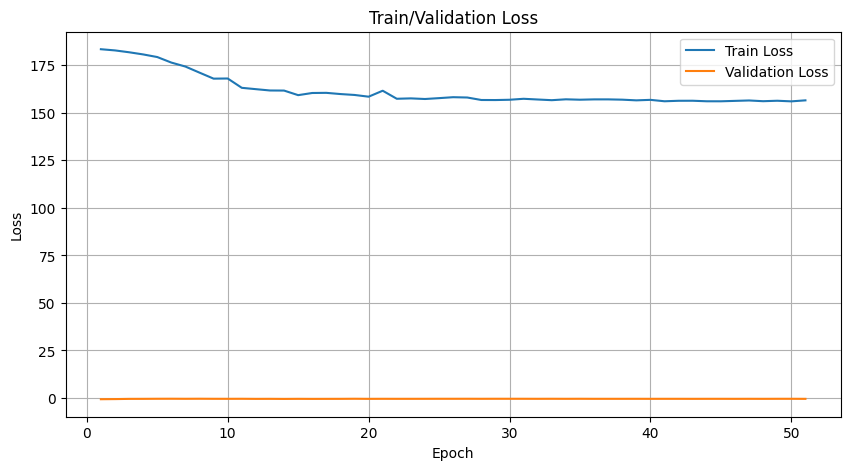

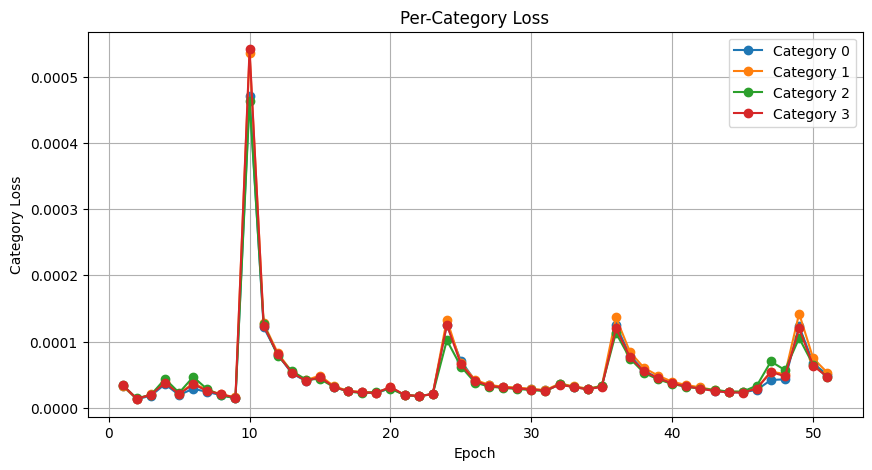

In [6]:
plot_training_history(history)

In [4]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_v2/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [ ]:
plot_patient_risk_score(model, test_loader, patient_index=400, device=device)

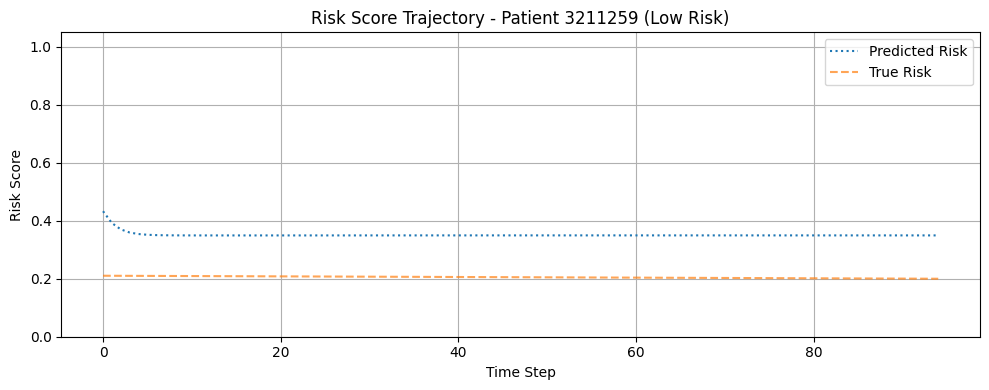

In [ ]:
plot_patient_risk_score(model, test_loader, patient_index=401, device=device)

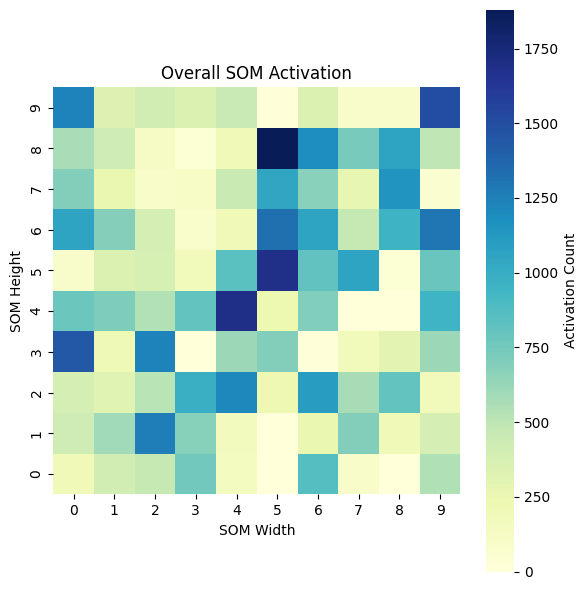

In [8]:

som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

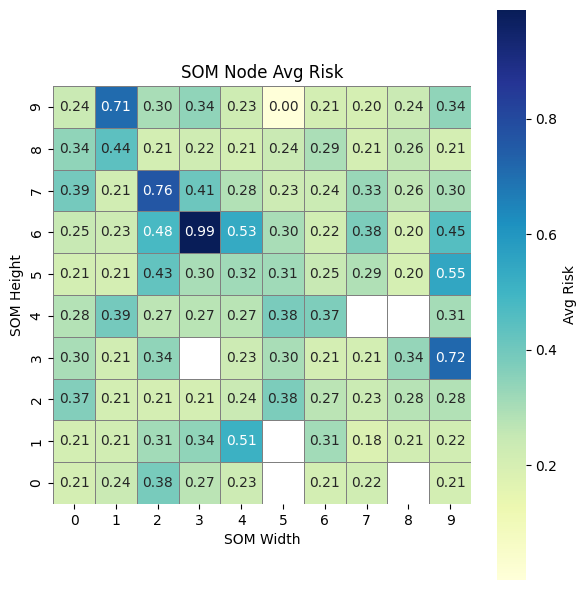

In [9]:

som_dim = (10,10)
avg_risk_map = compute_som_avg_risk(model, test_loader, device, som_dim)
plot_som_avg_risk(avg_risk_map, som_dim)